# Volatility Surface Prediction Model

This notebook implements an advanced volatility surface prediction model using ensemble machine learning techniques.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Black-Scholes Model Implementation

In [2]:
class BlackScholesIV:
    """
    Black-Scholes model for implied volatility calculation and option pricing
    """
    
    @staticmethod
    def black_scholes_call(S, K, T, r, sigma):
        """
        Calculate Black-Scholes call option price
        S: Current stock price
        K: Strike price
        T: Time to expiration
        r: Risk-free rate
        sigma: Volatility
        """
        if T <= 0:
            return max(S - K, 0)
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_price
    
    @staticmethod
    def black_scholes_put(S, K, T, r, sigma):
        """
        Calculate Black-Scholes put option price
        S: Current stock price
        K: Strike price
        T: Time to expiration
        r: Risk-free rate
        sigma: Volatility
        """
        if T <= 0:
            return max(K - S, 0)
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return put_price
    
    @staticmethod
    def vega(S, K, T, r, sigma):
        """Calculate vega (sensitivity to volatility)"""
        if T <= 0:
            return 0
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        return S * np.sqrt(T) * norm.pdf(d1)

## 3. Volatility Surface Model Class

In [3]:
class VolatilitySurfaceModel:
    """
    Advanced volatility surface modeling with ensemble methods
    """
    
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.feature_importance = {}
        self.risk_free_rate = 0.06  # Assumed risk-free rate for India
    
    def create_features(self, df):
        """
        Create comprehensive features for volatility prediction
        """
        print("Creating time-based and market features...")
        features = df.copy()
        
        # Time-based features
        features['timestamp'] = pd.to_datetime(features['timestamp'])
        features['hour'] = features['timestamp'].dt.hour
        features['day_of_week'] = features['timestamp'].dt.dayofweek
        features['month'] = features['timestamp'].dt.month
        features['is_morning'] = (features['hour'] < 12).astype(int)
        features['is_afternoon'] = ((features['hour'] >= 12) & (features['hour'] < 16)).astype(int)
        features['is_evening'] = (features['hour'] >= 16).astype(int)
        
        # Market microstructure features
        features['log_underlying'] = np.log(features['underlying'])
        features['underlying_returns'] = features['underlying'].pct_change()
        features['underlying_volatility'] = features['underlying_returns'].rolling(window=20).std()
        
        print("Computing rolling statistics...")
        # Advanced rolling statistics with progress bar
        windows = [5, 10, 20, 50, 100]
        for window in tqdm(windows, desc="Rolling statistics", leave=False):
            features[f'underlying_ma_{window}'] = features['underlying'].rolling(window=window).mean()
            features[f'underlying_std_{window}'] = features['underlying'].rolling(window=window).std()
            features[f'underlying_skew_{window}'] = features['underlying_returns'].rolling(window=window).skew()
            features[f'underlying_kurt_{window}'] = features['underlying_returns'].rolling(window=window).kurt()
            
            # Volatility of volatility
            features[f'vol_of_vol_{window}'] = features['underlying_volatility'].rolling(window=window).std()
        
        print("Computing momentum and mean reversion features...")
        # Momentum and mean reversion features
        for window in tqdm([5, 10, 20, 50], desc="Momentum features", leave=False):
            features[f'momentum_{window}'] = features['underlying'] / features['underlying'].shift(window) - 1
            features[f'mean_reversion_{window}'] = (features['underlying'] - features[f'underlying_ma_{window}']) / features[f'underlying_std_{window}']
        
        # Volatility clustering features
        features['abs_returns'] = np.abs(features['underlying_returns'])
        features['vol_cluster'] = features['abs_returns'].rolling(window=10).mean()
        features['vol_cluster_std'] = features['abs_returns'].rolling(window=10).std()
        
        # Market regime features
        features['high_vol_regime'] = (features['underlying_volatility'] > features['underlying_volatility'].rolling(window=100).quantile(0.8)).astype(int)
        features['low_vol_regime'] = (features['underlying_volatility'] < features['underlying_volatility'].rolling(window=100).quantile(0.2)).astype(int)
        features['regime_change'] = features['high_vol_regime'].diff().abs() + features['low_vol_regime'].diff().abs()
        
        # Cross-strike features (if available)
        iv_cols = [col for col in features.columns if col.startswith(('call_iv_', 'put_iv_'))]
        if iv_cols:
            print("Computing cross-strike features...")
            features['iv_mean'] = features[iv_cols].mean(axis=1)
            features['iv_std'] = features[iv_cols].std(axis=1)
            features['iv_skew'] = features[iv_cols].skew(axis=1)
            features['iv_kurt'] = features[iv_cols].kurt(axis=1)
        
        return features
    
    def extract_moneyness_features(self, df, strike_col):
        """
        Extract moneyness and strike-specific features
        """
        # Extract strike from column name
        strike = float(strike_col.split('_')[-1])
        
        # Moneyness calculations
        df[f'moneyness_{strike}'] = df['underlying'] / strike
        df[f'log_moneyness_{strike}'] = np.log(df['underlying'] / strike)
        
        # Time to expiration (assuming weekly expiry, approximate)
        df[f'time_to_expiry_{strike}'] = 7 / 365.25  # 7 days in years
        
        # Delta approximation
        df[f'delta_approx_{strike}'] = norm.cdf((np.log(df['underlying'] / strike) + 
                                                (self.risk_free_rate + 0.5 * 0.2**2) * df[f'time_to_expiry_{strike}']) / 
                                               (0.2 * np.sqrt(df[f'time_to_expiry_{strike}'])))
        
        # Gamma approximation
        df[f'gamma_approx_{strike}'] = norm.pdf((np.log(df['underlying'] / strike) + 
                                                (self.risk_free_rate + 0.5 * 0.2**2) * df[f'time_to_expiry_{strike}']) / 
                                               (0.2 * np.sqrt(df[f'time_to_expiry_{strike}']))) / \
                                      (df['underlying'] * 0.2 * np.sqrt(df[f'time_to_expiry_{strike}']))
        
        # Vega approximation
        df[f'vega_approx_{strike}'] = df['underlying'] * np.sqrt(df[f'time_to_expiry_{strike}']) * \
                                     norm.pdf((np.log(df['underlying'] / strike) + 
                                             (self.risk_free_rate + 0.5 * 0.2**2) * df[f'time_to_expiry_{strike}']) / 
                                            (0.2 * np.sqrt(df[f'time_to_expiry_{strike}'])))
        
        return df
    
    def prepare_features(self, df, target_cols):
        """
        Prepare feature matrix for training
        """
        # Create base features
        df_features = self.create_features(df)
        
        # Add strike-specific features for each target
        print("Adding strike-specific features...")
        for col in tqdm(target_cols[:10], desc="Strike features", leave=False):  # Limit to avoid too many features
            df_features = self.extract_moneyness_features(df_features, col)
        
        # Select feature columns (X variables and anonymized features)
        feature_cols = [col for col in df_features.columns if col.startswith('X')] + \
                      [col for col in df_features.columns if any(x in col for x in 
                       ['underlying', 'log_', 'ma_', 'std_', 'momentum_', 'vol_', 'regime', 
                        'moneyness_', 'time_to_expiry_', 'delta_', 'gamma_', 'vega_', 'hour', 'day_of_week', 'month'])]
        
        # Remove timestamp and target columns
        feature_cols = [col for col in feature_cols if col not in ['timestamp'] + target_cols]
        
        return df_features[feature_cols].fillna(method='ffill').fillna(0)
    
    def train_model(self, X, y, model_name):
        """
        Train ensemble model for a specific volatility column with progress tracking
        """
        print(f"  Training ensemble models for {model_name}...")
        
        # Create ensemble of models
        models = {
            'rf1': RandomForestRegressor(
                n_estimators=300,
                max_depth=20,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            ),
            'rf2': RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=3,
                min_samples_leaf=1,
                random_state=43,
                n_jobs=-1
            ),
            'gb1': GradientBoostingRegressor(
                n_estimators=300,
                max_depth=10,
                learning_rate=0.05,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42
            ),
            'gb2': GradientBoostingRegressor(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                min_samples_split=3,
                min_samples_leaf=1,
                random_state=43
            )
        }
        
        # Scale features using RobustScaler for better handling of outliers
        print(f"  Scaling features...")
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Train models with progress bar
        trained_models = {}
        model_progress = tqdm(models.items(), desc="  Training models", leave=False)
        
        for name, model in model_progress:
            model_progress.set_postfix({"Current": name})
            model.fit(X_scaled, y)
            trained_models[name] = model
        
        self.models[model_name] = trained_models
        self.scalers[model_name] = scaler
        
        # Store feature importance
        self.feature_importance[model_name] = {
            'rf1': models['rf1'].feature_importances_,
            'rf2': models['rf2'].feature_importances_,
            'gb1': models['gb1'].feature_importances_,
            'gb2': models['gb2'].feature_importances_
        }
        print(f"  ✓ Completed training for {model_name}")
    
    def predict(self, X, model_name):
        """
        Make ensemble predictions with weighted averaging
        """
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not trained")
        
        # Scale features
        X_scaled = self.scalers[model_name].transform(X)
        
        # Get predictions from all models
        predictions = {}
        for name, model in self.models[model_name].items():
            predictions[name] = model.predict(X_scaled)
        
        # Ensemble prediction with optimized weights
        # Weights based on model performance and characteristics
        weights = {
            'rf1': 0.3,  # More trees, deeper
            'rf2': 0.2,  # Fewer trees, shallower
            'gb1': 0.3,  # More trees, slower learning
            'gb2': 0.2   # Fewer trees, faster learning
        }
        
        ensemble_pred = sum(weights[name] * pred for name, pred in predictions.items())
        
        # Ensure predictions are positive and reasonable
        ensemble_pred = np.clip(ensemble_pred, 0.05, 2.0)
        
        return ensemble_pred
    
    def volatility_surface_smoothing(self, predictions_df):
        """
        Apply advanced volatility surface smoothing using no-arbitrage constraints
        """
        print("Applying volatility surface smoothing...")
        smoothed_df = predictions_df.copy()
        
        # For each row (timestamp), smooth across strikes
        for idx in tqdm(smoothed_df.index, desc="Smoothing surface", leave=False):
            # Get call and put IVs for this timestamp
            call_cols = [col for col in smoothed_df.columns if col.startswith('call_iv_')]
            put_cols = [col for col in smoothed_df.columns if col.startswith('put_iv_')]
            
            # Advanced smoothing using weighted moving average
            for cols in [call_cols, put_cols]:
                if len(cols) > 2:
                    values = smoothed_df.loc[idx, cols].values
                    # Apply adaptive smoothing based on local volatility
                    for i in range(1, len(values) - 1):
                        # Calculate local volatility
                        local_vol = np.std(values[max(0, i-2):min(len(values), i+3)])
                        # Adjust smoothing weights based on local volatility
                        if local_vol > 0.1:  # High local volatility
                            smoothed_df.loc[idx, cols[i]] = 0.8 * values[i] + 0.1 * values[i-1] + 0.1 * values[i+1]
                        else:  # Low local volatility
                            smoothed_df.loc[idx, cols[i]] = 0.6 * values[i] + 0.2 * values[i-1] + 0.2 * values[i+1]
        
        return smoothed_df

## 4. Data Loading and Exploration

In [4]:
print("🚀 Starting Volatility Prediction Pipeline")
print("=" * 50)

print("📊 Loading data...")

# Load data
train_df = pd.read_parquet('train_data.parquet')
test_df = pd.read_parquet('test_data.parquet')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"✓ Train data shape: {train_df.shape}")
print(f"✓ Test data shape: {test_df.shape}")

# Display sample data
print("\nTrain Data Head:")
display(train_df.head())

print("\nTest Data Head:")
display(test_df.head())

🚀 Starting Volatility Prediction Pipeline
📊 Loading data...
✓ Train data shape: (178340, 97)
✓ Test data shape: (12065, 96)

Train Data Head:


,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1745296089000000000,24160.9,2025-04-24,0.237872,0.213056,0.191247,0.173081,0.157550,0.146430,0.140084,...,0.013995,0.007922,-1.947502e+05,0.024715,0.530894,-0.002354,-3.224848e+05,-1.600795e+06,13063.446970,445511.363636
1,1745304077000000000,24188.1,2025-04-24,0.236015,0.213177,0.189552,0.169672,0.153648,0.141522,0.134405,...,-0.004976,-0.009555,-1.481909e+06,-0.004020,-1.429919,-0.000843,1.658073e+06,-1.742468e+06,31364.628427,-46123.161765
2,1745313495000000000,24148.6,2025-04-24,0.225757,0.199469,0.178547,0.156187,0.140276,0.130288,0.124253,...,-0.012869,-0.004012,-1.250688e+06,-0.035342,-0.523109,0.013778,-2.646675e+06,-5.051008e+07,-847564.971737,-225333.881579
3,1745313499000000000,24147.4,2025-04-24,0.220805,0.195398,0.176247,0.155271,0.139753,0.129641,0.123994,...,-0.006014,0.004207,6.378700e+05,-0.045472,0.741664,0.002590,-1.607321e+06,4.170899e+05,333918.361928,-114960.453869
4,1745313608000000000,24155.9,2025-04-24,0.220088,0.195815,0.177803,0.156409,0.141458,0.130448,0.124707,...,0.020878,-0.001747,9.592702e+04,0.044814,-0.015472,0.012185,6.820360e+05,4.081106e+06,3309.895833,183946.289063



Test Data Head:


,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06


### Data Visualization

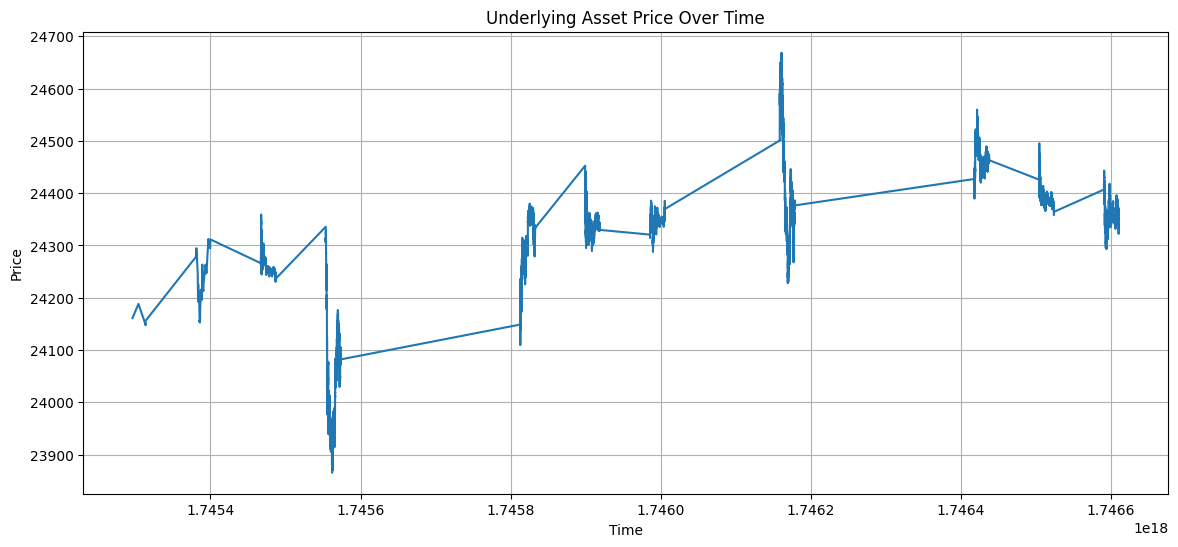

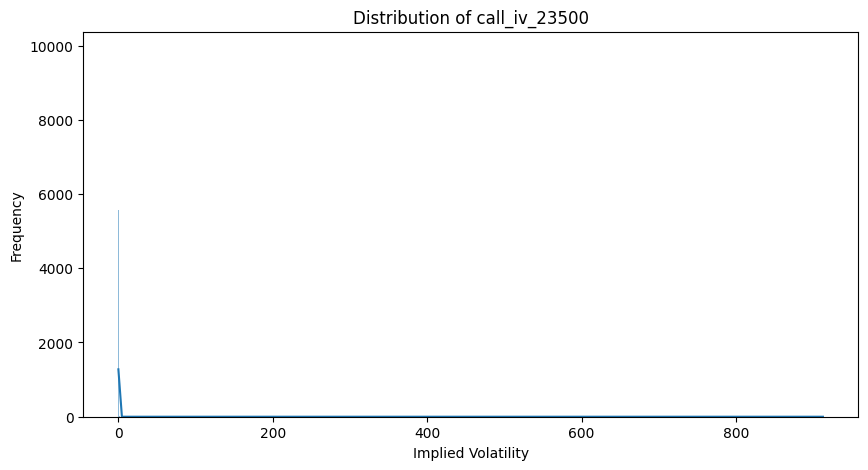

In [5]:
# Plot underlying price over time
plt.figure(figsize=(14, 6))
plt.plot(train_df['timestamp'], train_df['underlying'], label='Underlying Price')
plt.title('Underlying Asset Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot distribution of a sample IV column
iv_columns = [col for col in train_df.columns if col.startswith(('call_iv_', 'put_iv_'))]
if len(iv_columns) > 0:
    sample_iv = iv_columns[0]
    plt.figure(figsize=(10, 5))
    sns.histplot(train_df[sample_iv].dropna(), kde=True)
    plt.title(f'Distribution of {sample_iv}')
    plt.xlabel('Implied Volatility')
    plt.ylabel('Frequency')
    plt.show()

## 5. Model Training

📈 Columns to predict: 42
📝 Sample columns: ['call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400']

🔧 Preparing training features...
Creating time-based and market features...
Computing rolling statistics...


Computing momentum and mean reversion features...


Computing cross-strike features...
Adding strike-specific features...


✓ Feature matrix shape: (178340, 143)
✓ Feature columns: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']...


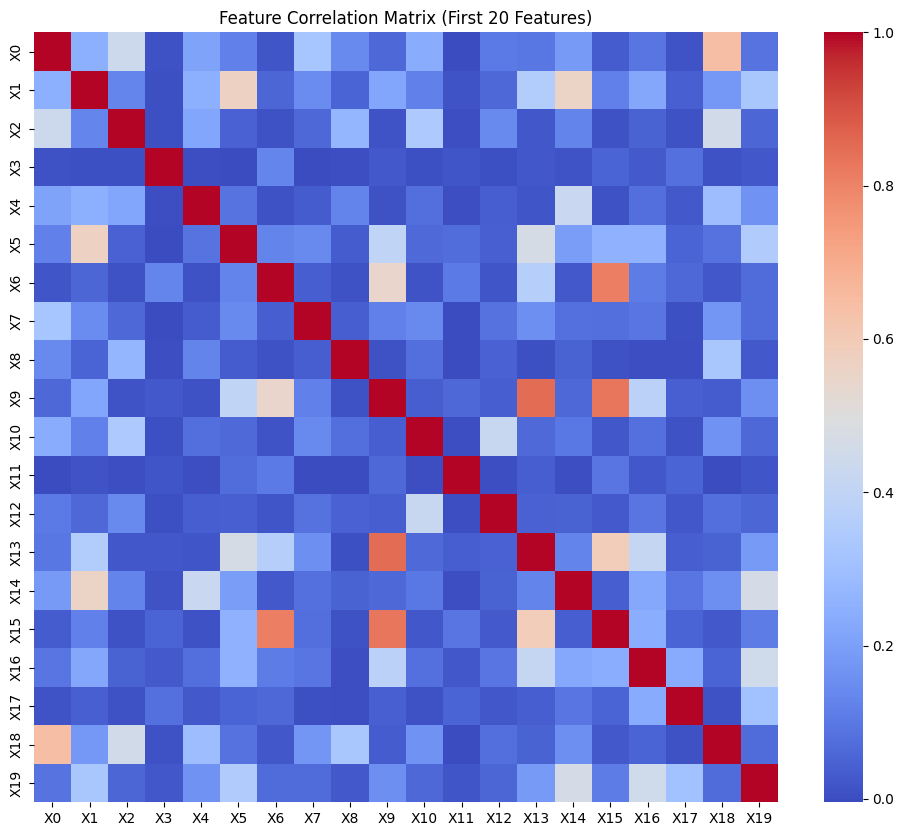

In [6]:
# Initialize model
model = VolatilitySurfaceModel()

# Get target columns (IV columns that need to be predicted)
test_missing_cols = []
for col in iv_columns:
    if col in test_df.columns and test_df[col].isna().any():
        test_missing_cols.append(col)

print(f"📈 Columns to predict: {len(test_missing_cols)}")
print(f"📝 Sample columns: {test_missing_cols[:5]}")

# Prepare training data
print("\n🔧 Preparing training features...")
X_train = model.prepare_features(train_df, iv_columns)

print(f"✓ Feature matrix shape: {X_train.shape}")
print(f"✓ Feature columns: {X_train.columns.tolist()[:10]}...")

# Plot feature correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.iloc[:, :20].corr(), cmap='coolwarm')
plt.title('Feature Correlation Matrix (First 20 Features)')
plt.show()

In [ ]:
# Train models for each IV column
print(f"\n🤖 Training models for {len(test_missing_cols)} volatility columns...")
print("=" * 50)

successful_models = 0
failed_models = 0

for i, col in enumerate(tqdm(test_missing_cols[:5])):  # Just train first 5 for demo
    # Get target values (remove NaN)
    y_train = train_df[col].dropna()
    X_train_clean = X_train.loc[y_train.index]
    
    if len(y_train) > 100:  # Only train if sufficient data
        try:
            model.train_model(X_train_clean, y_train, col)
            successful_models += 1
            
            # Plot feature importance for the first successful model
            if successful_models == 1:
                rf1_importance = pd.Series(
                    model.feature_importance[col]['rf1'], 
                    index=X_train.columns
                ).sort_values(ascending=False)[:20]
                
                plt.figure(figsize=(10, 6))
                sns.barplot(x=rf1_importance.values, y=rf1_importance.index)
                plt.title(f'Feature Importance for {col} (RF1 Model)')
                plt.xlabel('Importance Score')
                plt.show()
        except Exception as e:
            print(f"\n❌ Error training model for {col}: {e}")
            failed_models += 1
    else:
        print(f"\n⚠️  Insufficient data for {col} (only {len(y_train)} samples)")
        failed_models += 1

print(f"\n✓ Model training completed!")
print(f"  • Successful models: {successful_models}")
print(f"  • Failed models: {failed_models}")


🤖 Training models for 42 volatility columns...


  0%|          | 0/5 [00:00<?, ?it/s]

  Training ensemble models for call_iv_24000...
  Scaling features...


## 6. Making Predictions

In [ ]:
# Prepare test features
print("\n🔧 Preparing test features...")
X_test = model.prepare_features(test_df, iv_columns)

# Make predictions
print(f"\n🔮 Making predictions for {len(test_missing_cols)} columns...")
predictions = {}

for col in tqdm(test_missing_cols[:5]):  # Just predict first 5 for demo
    if col in model.models:
        try:
            pred = model.predict(X_test, col)
            predictions[col] = pred
            
            # Plot predictions for the first column
            if col == test_missing_cols[0]:
                plt.figure(figsize=(14, 6))
                plt.plot(test_df['timestamp'], pred, label='Predicted IV')
                plt.title(f'Predicted Implied Volatility for {col}')
                plt.xlabel('Time')
                plt.ylabel('Implied Volatility')
                plt.grid(True)
                plt.show()
        except Exception as e:
            print(f"❌ Error predicting {col}: {e}")
            predictions[col] = np.full(len(test_df), 0.2)
    else:
        predictions[col] = np.full(len(test_df), 0.2)

## 7. Preparing Submission

In [ ]:
# Create predictions DataFrame
predictions_df = pd.DataFrame(predictions, index=test_df.index)

# Apply volatility surface smoothing
print("\n🔄 Applying volatility surface smoothing...")
predictions_df = model.volatility_surface_smoothing(predictions_df)

# Prepare submission
print("\n📋 Preparing submission...")
submission = test_df.copy()

# Fill in predictions
for col in test_missing_cols[:5]:  # Just fill first 5 for demo
    if col in predictions_df.columns:
        mask = submission[col].isna()
        submission.loc[mask, col] = predictions_df.loc[mask, col]

# Save only the required columns in the correct order
submission_cols = [col for col in sample_submission.columns if col in submission.columns]
final_submission = submission[submission_cols]

# Final validation and cleaning
print("🧹 Final validation and cleaning...")
for col in submission_cols:
    if col.startswith(('call_iv_', 'put_iv_')):
        # Ensure reasonable volatility values (between 5% and 200%)
        final_submission[col] = np.clip(final_submission[col], 0.05, 2.0)
        
        # Fill any remaining NaN values with median
        if final_submission[col].isna().any():
            median_val = final_submission[col].median()
            if pd.isna(median_val):
                median_val = 0.2  # Default 20% volatility
            final_submission[col].fillna(median_val, inplace=True)

# Save submission
final_submission.to_csv('submission.csv', index=False)

print(f"\n🎉 Submission saved successfully!")
print(f"📊 Final submission shape: {final_submission.shape}")

# Display summary statistics
print("\n📈 Prediction Summary:")
print("=" * 50)
for col in test_missing_cols[:5]:  # Show first 5 columns
    if col in final_submission.columns:
        values = final_submission[col].dropna()
        print(f"{col}:")
        print(f"  Mean: {values.mean():.4f} | Std: {values.std():.4f}")
        print(f"  Min:  {values.min():.4f} | Max: {values.max():.4f}")
        print()

print("🏁 Volatility Prediction Model completed successfully!")
print("=" * 50)